In [1]:
import numpy as np
import os
from pathlib import Path, PureWindowsPath
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import TensorDataset, DataLoader, Dataset
from PIL import Image as im
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
data_path_train = "data/Training_set/"
subject = "subject_" # need to fill the last number
folder = "00000" # need to add the last three numbers
f = open(os.path.join(data_path_train, "train_pair.txt"), "r")
contents_train = f.readlines()
train_image, train_kp, gt_train_image = [], [], []
er = 0
for sample in contents_train:

    sample = sample.split()
    inp, gt = sample[0], sample[1] # , sample[2]
    # print(inp)
    # print(gt)
    # print(gt.split('.'))

    inp_1, inp_2 = inp.split('_')[0],  inp.split('_')[1]

    # input
    subject_in = subject + str(int(inp_1))
    folder_in = folder + inp_2

    # ground truth

    gt_1, gt_2 = gt.split('_')[0],  gt.split('_')[1]
    subject_gt = subject + str(int(gt_1))
    folder_gt = folder + gt_2


    # print(subject_in)
    # print(folder_in)

    # print(subject_gt)
    # print(folder_gt)

    im_train = data_path_train + subject_in + '/' + folder_in + '/image/' + inp
    kp_train = data_path_train + subject_gt + '/' + folder_gt + '/keypoints/' + gt.split('.')[0] + '.txt'

    im_gt = data_path_train + subject_gt + '/' + folder_gt + '/image/' + gt


    tmp_im = cv2.imread(im_train, 0)

    if tmp_im is not None:

        er_kp = np.loadtxt(kp_train)

        train_image.append(im_train)
        train_kp.append(kp_train)
        gt_train_image.append(im_gt)

    # print(im_train)
    # print(kp_train)
    # print(im_gt)

    

    # print(er_kp)

    if tmp_im is None:
        er += 1

    # print(tmp_im.shape)
    # print(train_image)
    # cv2.imshow(tmp_im)
    # plt.imshow(tmp_im, cmap='gray')
    # plt.show()

    # break


In [3]:
print(er)
print(len(gt_train_image))

1000
100000


In [4]:
def load_pose_cords_from_strings(keypoint):
    key2D = np.loadtxt(keypoint)
    x = np.array(18)
    y = np.array(18)

    x = key2D[:,0]
    y = key2D[:,1]
    y_cords = x#json.loads(y)
    x_cords = y#json.loads(x)

    return np.concatenate([np.expand_dims(y_cords, -1), np.expand_dims(x_cords, -1)], axis=1)

In [5]:
def gaussian(img, pt, sigma):
    # Draw a 2D gaussian
    if (pt[0] == 0.0) and (pt[1] == 0.0):
        return img

    # Check that any part of the gaussian is in-bounds
    ul = [int(pt[0] - 3 * sigma), int(pt[1] - 3 * sigma)]
    br = [int(pt[0] + 3 * sigma + 1), int(pt[1] + 3 * sigma + 1)]
    if (ul[0] > img.shape[1] or ul[1] >= img.shape[0] or
            br[0] < 0 or br[1] < 0):
        # If not, just return the image as is
        return img

    # Generate gaussian
    size = 6 * sigma + 1
    x = np.arange(0, size, 1, float)
    y = x[:, np.newaxis]
    x0 = y0 = size // 2
    # The gaussian is not normalized, we want the center value to equal 1
    g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

    # Usable gaussian range
    g_x = max(0, -ul[0]), min(br[0], img.shape[1]) - ul[0]
    g_y = max(0, -ul[1]), min(br[1], img.shape[0]) - ul[1]
    # Image range
    img_x = max(0, ul[0]), min(br[0], img.shape[1])
    img_y = max(0, ul[1]), min(br[1], img.shape[0])

    img[img_y[0]:img_y[1], img_x[0]:img_x[1]] = g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
    return img

In [6]:
def test(file):
    coor = load_pose_cords_from_strings(file)
    # print(coor)
    img = np.zeros((256,256))
    im_list = []
    for i in range(18):
    	
    	# img += gaussian(img,[coor[i,0],coor[i,1]], 5)
        im_list.append(gaussian(img,[coor[i,0],coor[i,1]], 1))
    

    for i in im_list:
        img += i
    
    #img = cv2.resize(img, ((64,64)))
    # plt.figure()
    # plt.imshow(img)
    # plt.show()
    return img

In [7]:
kp_images = []
gt_images = []
images = []
for i in range(50000): # len(train_kp)
    gt_im = test(train_kp[i])

    images.append(cv2.imread(train_image[i]))

    gt_images.append(cv2.imread(gt_train_image[i]))

    kp_images.append(gt_im)
    # if i == 5:
    #     break

In [8]:
len(kp_images)

50000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


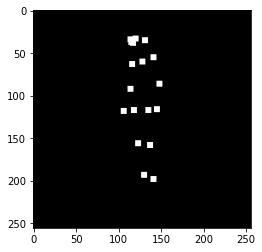

In [9]:
data = np.asarray(im.fromarray(kp_images[0]*255))

color_img = cv2.cvtColor(data, cv2.COLOR_GRAY2RGB)

plt.imshow(color_img)
plt.show()

In [10]:
cv2.imwrite( 'kp.jpeg',color_img)

True

In [11]:
# preprocess the input data
# concatenate source with keypoint
concat_data = []
concat_data2 = []
for i in range(len(images)):

    a = np.asarray(im.fromarray(kp_images[i]*255))
    col_a = cv2.cvtColor(a, cv2.COLOR_GRAY2RGB) # take the rgb of the key points

    kp_images[i] = cv2.resize(col_a, [64,64]) # /255

    images[i] = cv2.resize(images[i], [64,64])

    # print(kp_images[i].shape)
    # print(images[i].shape)
   

    im_v = images[i] + kp_images[i] # cv2.hconcat( [images[i], kp_images[i]+images[i]] )# .reshape(64,64,3)
    
    # print(im_v.shape)

    # resize image
    im_v = im_v

    concat_data.append(im_v) # .reshape([1,64,64])

    # reshape the gt images
    gt_images[i] = cv2.resize(gt_images[i], [64,64]) # .reshape([1,64,64]) # .reshape(256**2,1)

    im_v2 = gt_images[i] + kp_images[i]  # cv2.vconcat(gt_images[i], kp_images[i]).reshape(64,64,3)
    concat_data2.append(im_v2)

    # tmp = images[i] + col_a
    # plt.imshow(im_v)
    # plt.show()
    # print(im_v.shape)
    # break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


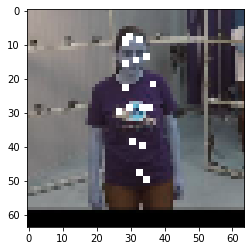

In [12]:

plt.imshow( concat_data[0].astype(int) )
plt.show()

In [13]:
cv2.imwrite( 'ex.jpeg',concat_data[0])

True

In [14]:
type(kp_images[0])

numpy.ndarray

In [15]:
print(concat_data2[0].shape)

(64, 64, 3)


In [16]:
class MyDataset(Dataset):
    def __init__(self, x, y, z= None, k=None, transform=None, target_transform=None):
        self.x = x.copy()
        self.y = y.copy()
        self.z = z.copy()
        self.k = k.copy()
        # self.data_paths = data_paths  # Could be a list: ['./train/input/image_1.bmp', './train/input/image_2.bmp', ...]
        # self.label_paths = label_paths  # Could be a nested list: [['./train/GT/image_1_1.bmp', './train/GT/image_1_2.bmp', ...], ['./train/GT/image_2_1.bmp', './train/GT/image_2_2.bmp', ...]]
        self.transform = transforms
        self.target_transform = target_transform
        
    def __getitem__(self, index):
        # x = Image.open(self.data_paths[index])
        # if self.transform:
        #     x = self.transform(x)

        # ys = []
        # for label_path in self.label_paths[index]:
        #     y = Image.open(label_path)
        #     if self.target_transform:
        #         y = self.target_transform(y)
        #     ys.append(y)

        return torch.Tensor(self.x[index]).permute(2,0,1), torch.Tensor(self.y[index]).permute(2,0,1), torch.Tensor(self.z[index]).permute(2,0,1), torch.Tensor(self.k[index]).permute(2,0,1) # , self.z[index].permute(2,0,1), self.k[index].permute(2,0,1)

    def __len__(self):
        return len(self.x)

In [17]:
# gt_images -> list of target images
# concat_data -> list of source im and keypoint concatenated
# images -> list of source images
# kp_images -> list of keypoints as images

my_x = concat_data # [0:1000]
my_y = gt_images # [0:1000]
my_z = images
my_k = kp_images
tensor_x1 = torch.Tensor(my_x)
tensor_x = torch.Tensor(my_x).permute(0,3,1,2)
tensor_y = torch.Tensor(my_y).permute(0,3,1,2)
tensor_z = torch.Tensor(my_z).permute(0,3,1,2)
tensor_k = torch.Tensor(my_k).permute(0,3,1,2)

print(tensor_x.shape)

dataset_x = MyDataset(my_x, my_y, my_z, my_k) # TensorDataset(tensor_x) , tensor_z, tensor_k
# dataset_y = TensorDataset(tensor_y)

# dataloader_x = DataLoader(dataset_x)
# dataloader_y = DataLoader(dataset_y)

dataloader_x = DataLoader(dataset_x, batch_size=64, shuffle=False, num_workers=2)
# dataloader_y = DataLoader(dataset_y, batch_size=64, shuffle=False, num_workers=2)

torch.Size([50000, 3, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 64, 3])


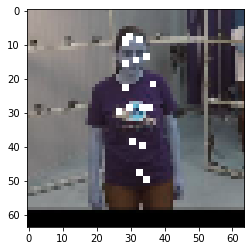

In [18]:
e = dataset_x.__getitem__(0)[0].permute(1,2,0) # .numpy()
print(e.shape)
i = tensor_x[0].permute(1,2,0)
plt.imshow(e.int()) # .astype(np.uint8))
plt.show()

In [19]:
# Generator
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # # input is Z, going into a convolution
            # nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            # nn.BatchNorm2d(ngf * 8),
            # nn.ReLU(True),
            # # state size. (ngf*8) x 4 x 4
            # nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf * 4),
            # nn.ReLU(True),
            # # state size. (ngf*4) x 8 x 8
            # nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf * 2),
            # nn.ReLU(True),
            # # state size. (ngf*2) x 16 x 16
            # nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            # nn.BatchNorm2d(ngf),
            # nn.ReLU(True),
            # # state size. (ngf) x 32 x 32
            # nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            # nn.Sigmoid()
            # # state size. (nc) x 64 x 64

            # nn.Linear(128,64),
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            # nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Conv2d(ndf * 8, nc, 3, 1, 1, bias=False), # (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1)
            nn.Sigmoid()

        )

    def forward(self, input):
        # x = self.main(input)
        # x = torch.max_pool3d(x, kernel_size=1)
        return self.main(input) # torch.sigmoid(x)

    def evaluate(self, input):
        return self.main(input)

In [20]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            # nn.Linear(128,64),
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [21]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [22]:
# Number of workers for dataloader
workers = 2
# Batch size during training
batch_size = 64
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 64**2 # 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 50 # 100
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 4

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
# print(device.type)

In [23]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# second network
netG2 = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG2 = nn.DataParallel(netG2, list(range(ngpu)))


# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))



In [24]:
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)
# Print the model
# print(netD)
# Initialize BCELoss function
criterion = nn.BCELoss()
criterion2 = nn.L1Loss()
criterion3 = nn.MSELoss()
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device) # + torch.[kp1.txt]
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
# Training Loop
# Lists to keep track of progress
img_list = []
img_list2 = []
G_losses = []
D_losses = []
iters = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader_x):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ############################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        # print(data[0].shape)
        target_im = data[1].to(device)/255
        b_size = target_im.size(0)

        template_im = data[2].to(device)/255
        kp_im = data[3].to(device)/255

        # print(b_size)
        # print(real_cpu.shape)

        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        label1 = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        
        # print('true pairs')
        # print(target_im.shape)
        # print(template_im.shape)

        # this increases some dimensions
        true_pair = target_im + template_im # torch.cat((target_im, template_im), -1) # keep row height and append in columns  
        # true_pair = torch.cat((target_im[::2], inputs[1::2]), 2)
        # print(true_pair.shape)

        # Forward pass real batch through D
        output = netD(true_pair).view(-1)
        # print(netD(true_pair).shape)


        # print('this is output')
        # print(output.shape)

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()


        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 3, 64, 64, device=device)*0

        # print(noise.shape)
        # Generate fake image batch with G
        source_data = data[0].to(device)/255 # .reshape(b_size, nz,3,1)


        # input to generator with source
        # fake_cat =  torch.cat((source_data, template_im), -1)

        fake = netG(source_data) # source_data was before here
        label1.fill_(fake_label)

        # nother Network
        # netG2(source_data)

        # input to generator with target
        # real_cat = torch.cat((target_im+kp_im, target_im ), -1)

        # fake_ = netG(real_cat)
        # label1.fill_(fake_label)




        fake_pair = fake + template_im # torch.cat((fake, template_im), -1) # keep row height and append in columns  
        # print(fake_pair.shape)
        # Classify all fake batch with D
        output = netD(fake_pair.detach()).view(-1)


        # print(output.shape)
        # print(label.shape)

        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label1)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ############################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake_pair).view(-1)
        # Calculate G's loss based on this output
        errG = criterion3(fake, target_im) + criterion2(fake, target_im)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader_x),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader_x)-1)):
            with torch.no_grad():
                fake = netG(source_data).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            img_list2.append(vutils.make_grid(target_im, padding=2, normalize=True))

        iters += 1



Starting Training Loop...
[0/50][0/782]	Loss_D: 1.7800	Loss_G: 0.2813	D(x): 0.3439	D(G(z)): 0.4282 / 0.5191
[0/50][50/782]	Loss_D: 0.0081	Loss_G: 0.2204	D(x): 0.9971	D(G(z)): 0.0051 / 0.0041
[0/50][100/782]	Loss_D: 0.0056	Loss_G: 0.1863	D(x): 0.9947	D(G(z)): 0.0002 / 0.0002
[0/50][150/782]	Loss_D: 0.0031	Loss_G: 0.1783	D(x): 0.9970	D(G(z)): 0.0001 / 0.0001
[0/50][200/782]	Loss_D: 0.0001	Loss_G: 0.1881	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/50][250/782]	Loss_D: 0.0004	Loss_G: 0.2253	D(x): 1.0000	D(G(z)): 0.0003 / 0.0003
[0/50][300/782]	Loss_D: 0.0006	Loss_G: 0.1955	D(x): 0.9994	D(G(z)): 0.0000 / 0.0000
[0/50][350/782]	Loss_D: 0.0056	Loss_G: 0.1968	D(x): 1.0000	D(G(z)): 0.0055 / 0.0018
[0/50][400/782]	Loss_D: 0.0000	Loss_G: 0.1892	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/50][450/782]	Loss_D: 0.0000	Loss_G: 0.1948	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/50][500/782]	Loss_D: 0.0001	Loss_G: 0.1893	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/50][550/782]	Loss_D: 0.0000	Loss_G: 0.1978	D(x): 1

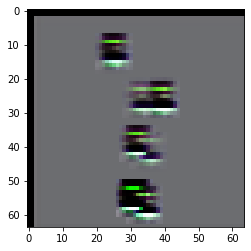

In [107]:
img_list[-1][0,:,:]
plt.imshow(img_list[-1][:,0:64,0:64].permute(1,2,0))
plt.show()

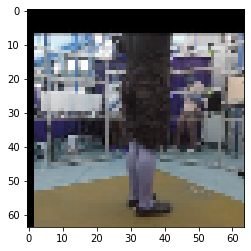

In [108]:
plt.imshow(img_list2[-1][:,0:64,0:64].permute(1,2,0).cpu())
plt.show()

In [27]:
cv2.imwrite( 'target1.jpeg',img_list2[-1][:,0:64,0:64].permute(1,2,0).cpu().numpy()*255)

True

In [28]:
cv2.imwrite( 'output1.jpeg',img_list[-1][:,0:64,0:64].permute(1,2,0).cpu().numpy()*255)

True

In [29]:
torch.save(netG.state_dict(), 'baseline2.pth')

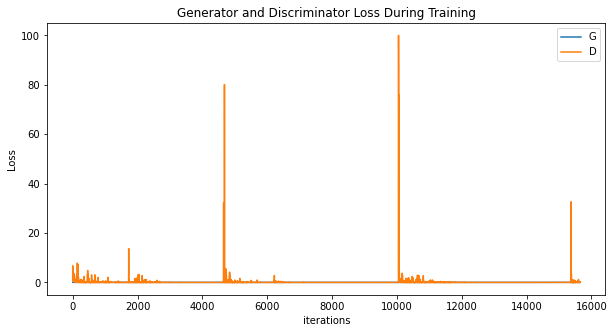

TypeError: Invalid shape (3, 530, 530) for image data

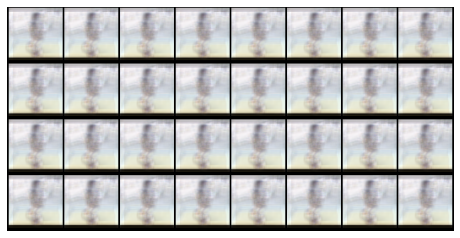

In [169]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

plt.imshow(img_list[1])
plt.show()

# Grab a batch of real images from the dataloader
# real_batch = next(iter(dataloader))

# # Plot the real images
# plt.figure(figsize=(15,15))
# plt.subplot(1,2,1)
# plt.axis("off")
# plt.title("Real Images")
# plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# # Plot the fake images from the last epoch
# plt.subplot(1,2,2)
# plt.axis("off")
# plt.title("Fake Images")
# plt.imshow(np.transpose(img_list[-1],(1,2,0)))
# plt.show()

In [125]:
results_path = "data/results/baseline2/"
data_path_test = "data/Testing_set2/"
# extract information from train.txt
f = open(os.path.join(data_path_test, "testing_set.txt"), "r")
contents_test = f.readlines()
test_image, test_kp, gt_test_image = [], [], []
for sample in contents_test:
    sample = sample.split()
    ii, kk, gi = sample[0], sample[1], sample[2]
    # print(data_path_test+ii)
    # print(data_path_test+kk)

    truth = gi.split('/')[1]

    test_image.append(data_path_test+ii)
    test_kp.append(data_path_test+kk)
    gt_test_image.append(truth)

    tmp_im = cv2.imread(data_path_test+ii, 0)

    er_kp = np.loadtxt(data_path_test+kk)

    # break

In [126]:
kp_images = []
images = []
for i in range(len(test_kp)):
    gt_im = test(test_kp[i])

    images.append(cv2.imread(test_image[i]))
    kp_images.append(gt_im)

In [127]:
# preprocess the input data
# concatenate source with keypoint
concat_data = []
concat_data2 = []
image_test_list = []
kp_image_list = []

for i in range(len(images)):

    a = np.asarray(im.fromarray(kp_images[i]*255))
    col_a = cv2.cvtColor(a, cv2.COLOR_GRAY2RGB) # take the rgb of the key points

    
    kp_image_list.append( cv2.resize(col_a, [64,64]) /255 )
    image_test_list.append( cv2.resize(images[i], [64,64]) /255 )


    im_v = kp_image_list[i] + image_test_list[i] # cv2.hconcat( [images[i], kp_images[i]+images[i]] )# .reshape(64,64,3)

    # resize image
    im_v = im_v
    concat_data.append(im_v) # .reshape([1,64,64])

In [128]:
image_test_list[0].shape
my_k = image_test_list[0].reshape(1,64,64,3)
tensor_k = torch.Tensor(my_k).permute(0,3,1,2)

In [129]:
tensor_k.shape

torch.Size([1, 3, 64, 64])

In [130]:
results_list = []
for i in range(len(concat_data)):
    my_k = concat_data[i].reshape(1,64,64,3)
    tensor_k = torch.Tensor(my_k).permute(0,3,1,2)
    result = netG(tensor_k)

    result = result.permute(0,2,3,1)

    with torch.no_grad():
        #print('yrs')
        result = result.detach().cpu()
    # img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    # img_list2.append(vutils.make_grid(target_im, padding=2, normalize=True))

    results_list.append(result)
    # break

In [131]:
cv2.imwrite( 'res1.jpeg',result[0,:,:,:].cpu().numpy()*255)

True

In [132]:
for i in range(len(gt_test_image)):
    name = gt_test_image[i]
    cv2.imwrite(results_path+name, results_list[i][0,:,:,:].cpu().numpy()*255)

In [133]:
gt_test_image[0]

'145_051_088_145_147_006.jpg'